# Regression and geography

When trying to determine the effect of some (independent) variables on
the outcome of phenomena (dependent variable), you often use regression
to model such an outcome and understand the influence each of the
variables has in the model. With spatial regression, it is the same. You
just need to use the spatial dimension in a mindful way.

This session provides an introduction to ways of incorporating space
into regression models, from spatial variables in standard linear
regression to geographically weighted regression.

In [2]:
import esda
import geopandas as gpd
import matplotlib.pyplot as plt
import mgwr
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as sm
from libpysal import graph

## Data

You will work with the same data you already used in the session on
[spatial autocorrelation](../autocorrelation/hands_on.qmd) - the results
of the second round of the presidential elections in Czechia in 2023,
between Petr Pavel and Andrej Babiš, on a level of municipalities. You
can read the election data directly from the original location.

In [ ]:
elections = gpd.read_file(
    "https://martinfleischmann.net/sds/autocorrelation/data/cz_elections_2023.gpkg"
)
elections = elections.set_index("name")
elections.head()



6254

> **Alternative**
>
> Instead of reading the file directly off the web, it is possible to
> download it manually, store it on your computer, and read it locally.
> To do that, you can follow these steps:
>
> 1.  Download the file by right-clicking on [this
>     link](https://martinfleischmann.net/sds/autocorrelation/data/cz_elections_2023.gpkg)
>     and saving the file
> 2.  Place the file in the same folder as the notebook where you intend
>     to read it
> 3.  Replace the code in the cell above with:
>
> ``` python
> elections = gpd.read_file(
>     "cz_elections_2023.gpkg",
> )
> ```

The election results give you the dependent variable - you will look at
the percentage of votes Petr Pavel, the winner, received. From the [map
of the results](../autocorrelation/hands_on.qmd#code-cell-2) and the
analysis you did when exploring spatial autocorrelation you already know
that there are some significant spatial patterns. Let’s look whether
these patterns correspond to the composition of education levels within
each municipality.

You can use the data from the [Czech Statistical
Office](https://www.czso.cz/csu/czso/vysledky-scitani-2021-otevrena-data)
reflecting the situation during the Census 2021. The original table has
been [preprocessed](../data/cz_education_2021/preprocessing.ipynb) and
is available as a CSV.

In [4]:
education = pd.read_csv(
    "https://martinfleischmann.net/sds/regression/data/education.csv"
)
education.head()

uzemi_kod  without_education  undetermined  incomplete_primary_education  \
0     500011           0.570704      3.741281                      1.141408   
1     500020           0.885827      3.346457                      1.968504   
2     500046           0.359195      3.232759                      0.790230   
3     500062           0.238237      3.573556                      1.072067   
4     500071           0.412939      2.890571                      1.238816   

   lower_secondary_and_secondary_education  further_education  \
0                                34.242232           1.775523   
1                                40.157480           2.066929   
2                                39.152299           2.514368   
3                                32.757594           2.084574   
4                                34.067447           1.720578   

   post_maturita_studies  bachelors_degree  doctoral_degree  masters_degree  \
0               0.507292          2.853519         0.634115       12.935954   
1               0.885827          1.771654         0.492126        6.299213   
2               0.790230          3.520115         0.215517       10.632184   
3               1.131626          3.037522         0.178678       13.281715   
4               0.757054          3.028217         0.137646       11.080523   

   higher_vocational_education  higher_vocational_education_in_a_conservatory  \
0                     1.395054                                       0.126823   
1                     1.574803                                       0.000000   
2                     1.364943                                       0.143678   
3                     0.714711                                       0.119119   
4                     0.894701                                       0.000000   

   primary_education  complete_secondary_vocational_education  \
0          11.350666                                17.945466   
1          15.059055                                16.338583   
2           9.770115                                15.301724   
3          11.316260                                18.701608   
4           9.772884                                20.027529   

   complete_secondary_general_education       okres  
0                             10.779962        Zlín  
1                              9.153543     Šumperk  
2                             12.212644  Nový Jičín  
3                             11.792734      Vsetín  
4                             13.971094      Vsetín

> **Alternative**
>
> Instead of reading the file directly off the web, it is possible to
> download it manually, store it on your computer, and read it locally.
> To do that, you can follow these steps:
>
> 1.  Download the file by right-clicking on [this
>     link](%22https://martinfleischmann.net/sds/regression/data/education.csv%22)
>     and saving the file
> 2.  Place the file in the same folder as the notebook where you intend
>     to read it
> 3.  Replace the code in the cell above with:
>
> ``` python
> education = pd.read_csv(
>     "education.csv",
> )
> ```

The first thing you need to do is to merge the two tables, to have both
dependent and independent variables together. The municipality code in
the `elections` table is in the `"nationalCode"` column, while in the
education table in the `"uzemi_kod"` column.

In [15]:
elections_data = elections.merge(education, left_on="nationalCode", right_on="uzemi_kod")
elections_data.head()

nationalCode  PetrPavel  AndrejBabis                          sourceOfName  \
0        500011      61.73        38.26  Český úřad zeměměřický a katastrální   
1        500020      49.07        50.92  Český úřad zeměměřický a katastrální   
2        500046      47.78        52.21  Český úřad zeměměřický a katastrální   
3        500062      58.79        41.20  Český úřad zeměměřický a katastrální   
4        500071      58.20        41.79  Český úřad zeměměřický a katastrální   

                                            geometry  uzemi_kod  \
0  MULTIPOLYGON (((-518835.63 -1170505.52, -51790...     500011   
1  MULTIPOLYGON (((-559207.18 -1075123.25, -55624...     500020   
2  MULTIPOLYGON (((-486502.29 -1123694.06, -48717...     500046   
3  MULTIPOLYGON (((-494514.83 -1136457.23, -49539...     500062   
4  MULTIPOLYGON (((-499678.51 -1143457.52, -49799...     500071   

   without_education  undetermined  incomplete_primary_education  \
0           0.570704      3.741281                      1.141408   
1           0.885827      3.346457                      1.968504   
2           0.359195      3.232759                      0.790230   
3           0.238237      3.573556                      1.072067   
4           0.412939      2.890571                      1.238816   

   lower_secondary_and_secondary_education  ...  post_maturita_studies  \
0                                34.242232  ...               0.507292   
1                                40.157480  ...               0.885827   
2                                39.152299  ...               0.790230   
3                                32.757594  ...               1.131626   
4                                34.067447  ...               0.757054   

   bachelors_degree  doctoral_degree  masters_degree  \
0          2.853519         0.634115       12.935954   
1          1.771654         0.492126        6.299213   
2          3.520115         0.215517       10.632184   
3          3.037522         0.178678       13.281715   
4          3.028217         0.137646       11.080523   

   higher_vocational_education  higher_vocational_education_in_a_conservatory  \
0                     1.395054                                       0.126823   
1                     1.574803                                       0.000000   
2                     1.364943                                       0.143678   
3                     0.714711                                       0.119119   
4                     0.894701                                       0.000000   

   primary_education  complete_secondary_vocational_education  \
0          11.350666                                17.945466   
1          15.059055                                16.338583   
2           9.770115                                15.301724   
3          11.316260                                18.701608   
4           9.772884                                20.027529   

   complete_secondary_general_education       okres  
0                             10.779962        Zlín  
1                              9.153543     Šumperk  
2                             12.212644  Nový Jičín  
3                             11.792734      Vsetín  
4                             13.971094      Vsetín  

[5 rows x 21 columns]

That is all sorted and ready to be used in a regression.

## Non-spatial linear regression

Before jumping into spatial regression, let’s start with the standard
linear regression. A useful start is to explore the data using an
ordinary least squares (OLS) linear regression model.

### OLS model

While this course is not formula-heavy, in this case, it is useful to
use the formula to explain the logic of the algorithm. The OLS tries to
model the dependent variable $y$ as the linear combination of
independent variables $x_1, x_2, ... x_n$:

$$y_{i}=\alpha+\beta _{1}\ x_{i1}+\beta _{2}\ x_{i2}+\cdots +\beta _{p}\ x_{ip}+\varepsilon _{i}$$

where $\epsilon_{i}$ represents unobserved random variables and $\alpha$
represents an intercept - a constant. You know the $y_i$, all of the
$x_i$ and try to estimate the coefficients. In Python, you can run
linear regression using implementations from more than one package
(e.g., `statsmodels`, `scikit-learn`, `spreg`). This course covers
`statsmodels` approach as it has a nice API to work with.

First, you need a list of names of independent variables. That is equal
to column names without a few of the columns that represent other data.

In [16]:
independent_names = education.columns.drop(["uzemi_kod", "okres"])
independent_names

Index(['without_education', 'undetermined', 'incomplete_primary_education',
       'lower_secondary_and_secondary_education', 'further_education',
       'post_maturita_studies', 'bachelors_degree', 'doctoral_degree',
       'masters_degree', 'higher_vocational_education',
       'higher_vocational_education_in_a_conservatory', 'primary_education',
       'complete_secondary_vocational_education',
       'complete_secondary_general_education'],
      dtype='object')

`statsmodels` (above imported as `sm`) offers an intuitive formula API
to define the linear regression.

In [17]:
formula = f"PetrPavel ~ {' + '.join(independent_names)}"
formula

'PetrPavel ~ without_education + undetermined + incomplete_primary_education + lower_secondary_and_secondary_education + further_education + post_maturita_studies + bachelors_degree + doctoral_degree + masters_degree + higher_vocational_education + higher_vocational_education_in_a_conservatory + primary_education + complete_secondary_vocational_education + complete_secondary_general_education'

With the formula ready, you can fit the model and estimate all betas and
$\varepsilon$.

In [18]:
ols = sm.ols(formula, data=elections_data).fit()

The `ols` object offers a handy `summary()` function providing most of
the results from the fitting in one place.

In [19]:
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              PetrPavel   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                     352.6
Date:                Tue, 03 Dec 2024   Prob (F-statistic):               0.00
Time:                        18:13:48   Log-Likelihood:                -22397.
No. Observations:                6254   AIC:                         4.482e+04
Df Residuals:                    6240   BIC:                         4.492e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
Intercept                                         0.1283      0.006     19.748      0.000       0.116       0.141
without_education                                 0.3621      0.093      3.914      0.000       0.181       0.543
undetermined                                      0.1879      0.041      4.542      0.000       0.107       0.269
incomplete_primary_education                     -0.0881      0.119     -0.737      0.461      -0.322       0.146
lower_secondary_and_secondary_education           0.2890      0.013     21.435      0.000       0.263       0.315
further_education                                 0.9665      0.116      8.312      0.000       0.739       1.194
post_maturita_studies                             1.3528      0.204      6.635      0.000       0.953       1.752
bachelors_degree                                  1.1634      0.092     12.581      0.000       0.982       1.345
doctoral_degree                                   1.2223      0.220      5.550      0.000       0.791       1.654
masters_degree                                    1.1231      0.036     31.201      0.000       1.053       1.194
higher_vocational_education                       1.7312      0.132     13.124      0.000       1.473       1.990
higher_vocational_education_in_a_conservatory     2.7664      0.577      4.796      0.000       1.636       3.897
primary_education                                 0.0723      0.033      2.213      0.027       0.008       0.136
complete_secondary_vocational_education           0.8683      0.032     27.316      0.000       0.806       0.931
complete_secondary_general_education              0.8121      0.038     21.247      0.000       0.737       0.887
==============================================================================
Omnibus:                      130.315   Durbin-Watson:                   1.680
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              215.929
Skew:                           0.189   Prob(JB):                     1.29e-47
Kurtosis:                       3.828   Cond. No.                     4.70e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.01e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

It is clear that education composition has a significant effect on the
outcome of the elections but can explain only about 42% of its variance
(adjusted $R^2$ is 0.422). A higher amount of residents with only
primary education tends to lower Pavel’s gain while a higher amount of
university degrees tends to increase the number of votes he received.
That is nothing unexpected. However, let’s make use of geography and
unpack these results a bit.

### Spatial exploration of the model (hidden structures)

Start with the visualisation of the prediction the OLS model produces
using the coefficients shown above.

In [20]:
predicted = ols.predict(elections_data)
predicted.head()

0    59.782801
1    50.879659
2    58.582439
3    60.674179
4    60.372217
dtype: float64

Make a plot comparing the prediction with the actual results.

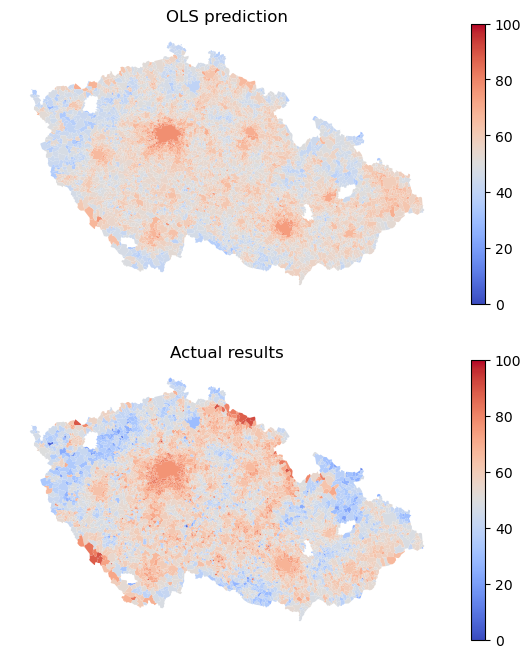

In [21]:
f, axs = plt.subplots(2, 1, figsize=(7, 8))
elections_data.plot(
    predicted, legend=True, cmap="coolwarm", vmin=0, vmax=100, ax=axs[0]
)
elections_data.plot(
    "PetrPavel", legend=True, cmap="coolwarm", vmin=0, vmax=100, ax=axs[1]
)
axs[0].set_title("OLS prediction")
axs[1].set_title("Actual results")

axs[0].set_axis_off()
axs[1].set_axis_off()

The general patterns are captured but there are some areas of the
country which seem to be quite off. The actual error between prediction
and the dependent variable is captured as *residuals*, which are
directly available in `ols` as `ols.resid` attribute. Let’s plot to get
a better comparison.

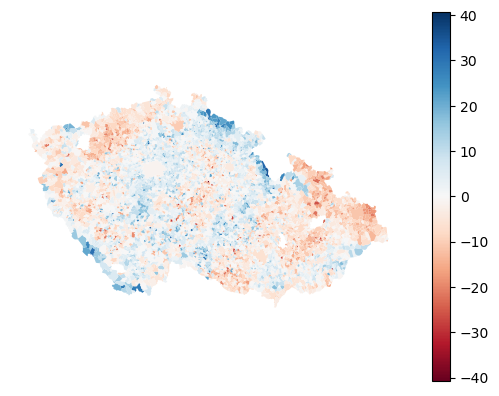

In [22]:
elections_data["residual"] = ols.resid
max_residual = ols.resid.abs().max()
ax = elections_data.plot(
    "residual", legend=True, cmap="RdBu", vmin=-max_residual, vmax=max_residual
)
ax.set_axis_off()

All of the municipalities in blue (residual above 0) have reported
higher gains for Petr Pavel than the model assumes based on education
structure, while all in red reported lower gains than what is expected.
However, as data scientists, we have better tools to analyse the spatial
structure of residuals than eyeballing it. Let’s recall the session on
spatial autocorrelation again and figure out the spatial clusters of
residuals.

First, create a contiguity graph and row-normalise it.

In [23]:
contiguity_r = graph.Graph.build_contiguity(elections_data).transform("r")

Then you can generate a Moran plot of residuals. For that, you will need
the lag of residuals.

In [24]:
elections_data["residual_lag"] = contiguity_r.lag(elections_data["residual"])

And then you can use the code from the earlier session to generate a
Moran scatterplot using `seaborn`.

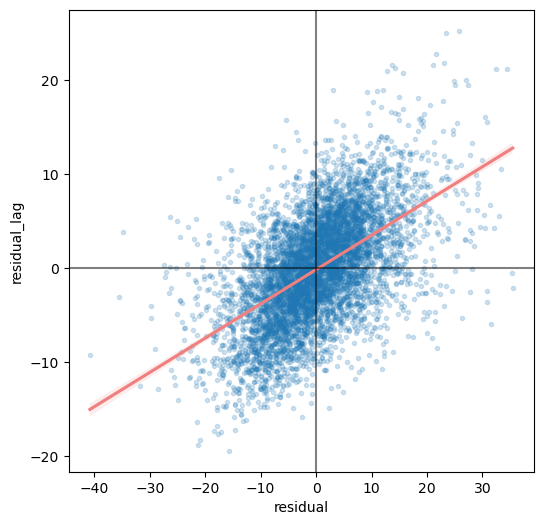

In [25]:
f, ax = plt.subplots(1, figsize=(6, 6))
sns.regplot(
    x="residual",
    y="residual_lag",
    data=elections_data,
    marker=".",
    scatter_kws={"alpha": 0.2},
    line_kws=dict(color="lightcoral")
)
plt.axvline(0, c="black", alpha=0.5)
plt.axhline(0, c="black", alpha=0.5);

That looks like a pretty strong relationship. Use the local version of
Moran’s statistic to find out the clusters.

In [26]:
lisa = esda.Moran_Local(elections_data['residual'], contiguity_r)

Let’s visualise the results.

In [27]:
lisa.explore(elections_data, prefer_canvas=True, tiles="CartoDB Positron")

The outcome of LISA shows large clusters of both overpredicted
(High-High) and underpredicted (Low-Low) areas. The underpredicted are
mostly in central Bohemia around Prague and in the mountains near the
borders, where the ski resorts are. Putting aside the central areas for
a bit, the explanation of underprediction in mountains is relatively
straightforward. The education data are linked to the residents of each
municipality. The people who voted in a municipality do not necessarily
need to match with residents. It is known that more affluent population
groups, who are more likely to go to a ski resort, voted overwhelmingly
for Pavel. And since the elections were in winter, a lot of them likely
voted in ski resorts, affecting the outcome of the model.

The overpredicted areas, on the other hand, are known for higher levels
of deprivation, which may have played a role in the results. What is
clear, is that geography plays a huge role in the modelling of the
elections.

## Spatial heterogeneity

Not all areas behave equally, it seems that some systematically vote for
Pavel more than for Babiš while others vote for him less. You need to
account for this when building a regression model. One way is by
capturing *spatial heterogeneity*. It implicitly assumes that the
outcome of the model spatially varies. You can expect $\alpha$ to vary
across space, or individual values of $\beta$. Spatial fixed effects
capture the former.

### Spatial fixed effects

You need to find a way to let $\alpha$ change across space. One option
is through the proxy variable capturing higher-level geography. You have
information about *okres* (the closest translation to English would
probably be district or county) each municipality belongs to. Let’s
start by checking if that could be useful by visualising residuals
within each. While you can use the box plot directly, it may be better
to sort the values by median residuals, so let’s complicate the code a
bit.

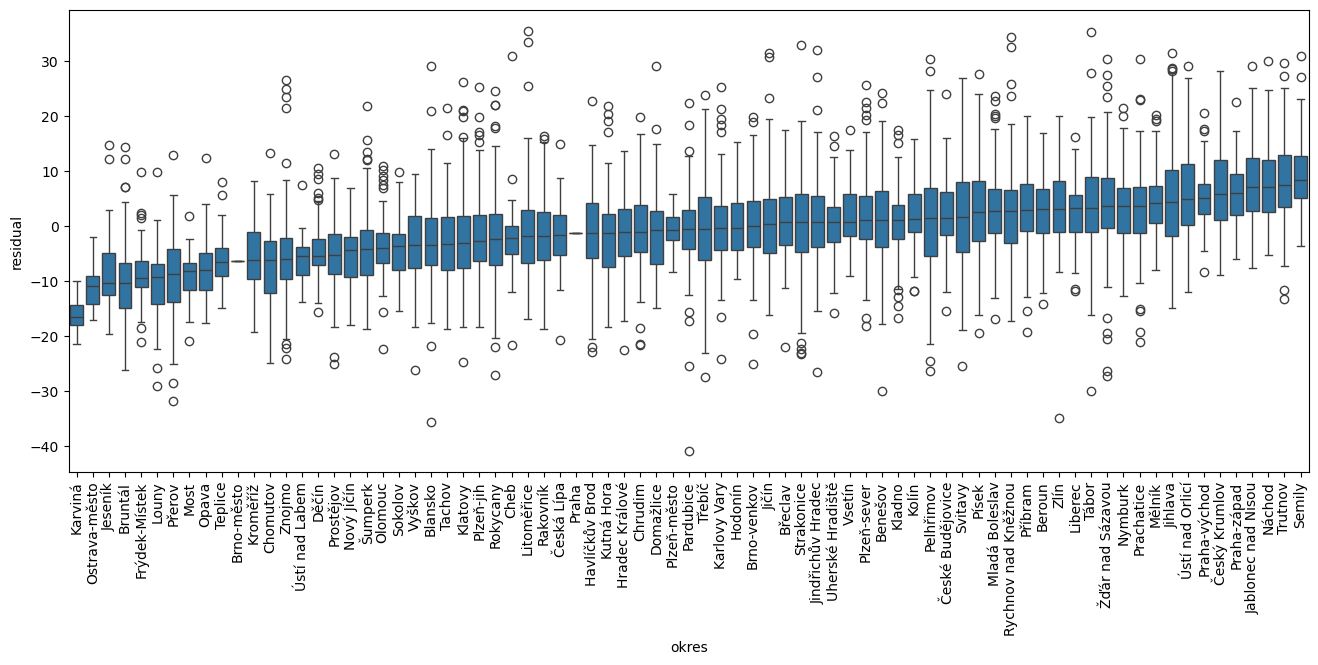

In [ ]:
medians = (
    elections_data.groupby("okres")
    .residual.median()
    .to_frame("okres_residual")
)
f, ax = plt.subplots(figsize=(16, 6))
sns.boxplot(
    data=elections_data.merge(
        medians, how="left", left_on="okres", right_index=True
    ).sort_values("okres_residual"),
    x="okres",
    y="residual",
)
_ = plt.xticks(rotation=90) # v grafu jsou serazeny vsechny okresy podle toho, zda jsou jednotlive okresy podhodnoceny (vlevo) a nadhodnoceny (vpravo)

There are clear differences among these geographies, with a gradient
between median -16.5 and 8.3. In a model that does not show spatial
heterogeneity across higher-level geographies like these, all medians
would be close to zero. This is positive information as it indicates,
that we can encode these geographies in the model as a spatial proxy.
Using `statsmodels`, you can adapt the equation and include `"okres"` as
a dummy variable.

In [30]:
formula_fe = f"PetrPavel ~ {' + '.join(independent_names)} + okres - 1" # -1 odstrani intercept (alfu substituuje okres!!!)
ols_fe = sm.ols(formula_fe, data=elections_data).fit()

Since every unique value in the `"okres"` column is now treated as a
unique variable the summary is a bit longer than before.

In [31]:
ols_fe.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              PetrPavel   R-squared:                       0.571
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     92.21
Date:                Tue, 03 Dec 2024   Prob (F-statistic):               0.00
Time:                        18:29:15   Log-Likelihood:                -21472.
No. Observations:                6254   AIC:                         4.312e+04
Df Residuals:                    6164   BIC:                         4.373e+04
Df Model:                          89                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
okres[Benešov]                                    2.5515      0.725      3.520      0.000       1.131       3.972
okres[Beroun]                                     4.3517      0.834      5.219      0.000       2.717       5.986
okres[Blansko]                                   -1.0237      0.723     -1.416      0.157      -2.441       0.393
okres[Brno-město]                                -3.6810      7.473     -0.493      0.622     -18.331      10.968
okres[Brno-venkov]                                1.9413      0.593      3.276      0.001       0.779       3.103
okres[Bruntál]                                  -10.4042      0.938    -11.094      0.000     -12.243      -8.566
okres[Břeclav]                                    1.2036      0.957      1.258      0.209      -0.673       3.080
okres[Cheb]                                      -2.6902      1.204     -2.234      0.026      -5.051      -0.330
okres[Chomutov]                                  -7.3448      1.145     -6.417      0.000      -9.589      -5.101
okres[Chrudim]                                    0.5374      0.744      0.722      0.470      -0.921       1.996
okres[Domažlice]                                 -0.5435      0.880     -0.618      0.537      -2.268       1.181
okres[Děčín]                                     -4.6916      1.061     -4.424      0.000      -6.771      -2.613
okres[Frýdek-Místek]                             -7.5664      0.907     -8.345      0.000      -9.344      -5.789
okres[Havlíčkův Brod]                             0.3325      0.717      0.464      0.643      -1.073       1.738
okres[Hodonín]                                    0.5302      0.845      0.628      0.530      -1.126       2.187
okres[Hradec Králové]                            -0.0895      0.755     -0.119      0.906      -1.570       1.391
okres[Jablonec nad Nisou]                         9.3049      1.275      7.300      0.000       6.806      11.804
okres[Jeseník]                                   -7.5762      1.537     -4.930      0.000     -10.589      -4.564
okres[Jihlava]                                    5.8273      0.701      8.311      0.000       4.453       7.202
okres[Jindřichův Hradec]                          2.4094      0.749      3.218      0.001       0.942       3.877
okres[Jičín]                                      1.7354      0.735      2.362      0.018       0.295       3.176
okres[Karlovy Vary]                               0.3530      1.027      0.344      0.731      -1.661       2.367
okres[Karviná]                                  -15.8537      1.819     -8.716      0.000     -19.419     -12.288
okres[Kladno]                                     1.9768      0.771      2.564      0.010       0.465       3.488
okres

The coefficients for each of the values of the categorical variable
`"okres"` are considered spatial fixed effects. You can extract just
those from the model by getting the `.params` `Series` and filtering it.

In [32]:
fixed_effects = ols_fe.params.filter(like="okres")
fixed_effects.head()

okres[Benešov]        2.551453
okres[Beroun]         4.351734
okres[Blansko]       -1.023745
okres[Brno-město]    -3.681027
okres[Brno-venkov]    1.941320
dtype: float64

You can see that if you want to join this Series to the original
DataFrame, you need to extract the names of each *okres* from within the
square brackets.

In [33]:
fixed_effects.index = fixed_effects.index.str.strip(
    "okres["
).str.strip("]")
fixed_effects.head()

Benešov        2.551453
Beroun         4.351734
Blansko       -1.023745
Brno-město    -3.681027
Brno-venkov    1.941320
dtype: float64

The resulting Series can be merged with the `elections_data`, allowing
us to map the spatial fixed effects.

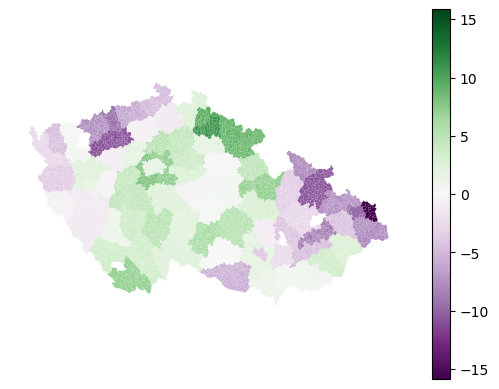

In [36]:
max_effect = fixed_effects.abs().max()
elections_data.merge(
    fixed_effects.to_frame("fixed_effect"),
    left_on="okres",
    right_index=True,
    how="left",
).plot(
    "fixed_effect", legend=True, vmin=-max_effect, vmax=max_effect, cmap="PRGn"
).set_axis_off() # v grafu jsou zobrazeny fixni efekty pro jednotlive okresy 

> **Spatial regimes and spatial dependence**
>
> Where spatial fixed effects allow $\alpha$ to change geographically
> (within each *okres*), spatial regimes allow $\beta_k$ to change
> within the same regions. Spatial regimes cannot be done within
> `statsmodels` as they require more specialised treatment offered by
> the `spreg` package. Check the [Spatial
> regimes](https://geographicdata.science/book/notebooks/11_regression.html#spatial-regimes)
> sections of the[*Spatial
> Regression*](https://geographicdata.science/book/notebooks/11_regression.html)
> chapter from the Geographic Data Science with Python by
> @rey2023geographic for more details.
>
> The same chapter also covers the modelling of spatial dependence using
> `spreg`. Both are considered advanced usage within this course but
> feel free to read through the materials yourself.

With spatial fixed effects, you were able to include spatial dimension
in the model through a proxy variable, resulting in an improvement of
adjusted $R^2$ from 0.422 to 0.565 while also extracting the fixed
effect of each *okres*. However, the model is still global. We are not
able to determine how explanatory is education composition regionally.

## Geographically weighted regression

Geographically Weighted Regression (GWR) overcomes the limitation of the
OLS, which provides a single global estimate by examining how the
relationship between a dependent variable and independent variable
changes across different geographic locations. It does this by moving a
search window through the dataset, defining regions around each
regression point, and fitting a regression model to the data within each
region. This process is repeated for all the sample points in the
dataset, resulting in localized estimates. These local estimates can
then be mapped to visualize variations in variable relationships at
different locations. However, for a dataset with 6254 observations, like
the one used here, GWR will fit 6254 weighted regression models. That
can eventually pose a limitation when dealing with larger datasets, for
which fitting the GWR can take too long.

Visually, you can imagine a spatial kernel being constructed around each
location (point, specifically) where the kernel function defines its
shape and bandwidth its size, as illustrated in
<a href="#fig-kernels" class="quarto-xref">Figure 1</a>.

<table>
<colgroup>
<col style="width: 50%" />
<col style="width: 50%" />
</colgroup>
<tbody>
<tr>
<td style="text-align: left;"><div width="50.0%"
data-layout-align="left">
<figure id="fig-bandwidth">
<img src="attachment:figures/bandwidth.png" />
<figcaption>(a) Illustration of bandwidth and its relation to
weight.</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div width="50.0%"
data-layout-align="left">
<figure id="fig-kernel">
<img src="attachment:figures/fixed_bandwidth.png" />
<figcaption>(b) Illustration of two spatial kernels across a point
pattern.</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

Figure 1: Illustrations of kernels. Reproduced from Fotheringham et al.
\[-@fotheringham2002geographically, pp.44-45\]

With kernels being the core of the GWR method, their specification
significantly affects the resulting model. You can specify three
parameters:

-   **Kernel shape**: The shape of the curve formed by the kernel. In
    `mgwr` package used here, `"bisquare"`, `"gaussian"`, and
    `"exponential"` kernels are supported.
-   **Kernel size**: The bandwidth distance specifying how large is the
    moving window.
-   **Bandwidth adaptivity**: Bandwidth can be either fixed, specified
    by the metric distance, where the moving window is essentially
    formed as a buffer around a point, or adaptive, specified by the
    number of nearest neighbours.

The details of the implications of the choices are beyond the scope of
this lesson but are discussed in-depth by
@fotheringham2002geographically.

### Fixed bandwidth

The method can be illustrated on a GWR using a fixed bandwidth and the
default bi-square kernel.

#### Bandwidth selection

You may have some theoretically defined bandwidth (e.g. you know that
you want to consider only locations closer than 25 km) or use
cross-validation to find the optimal bandwidth programmatically. CV can
be an expensive procedure as the selection procedure fits models based
on different bandwidths and compares residuals to choose the one where
those are minimised. `mgwr` has the `mgwr.sel_bw.Sel_BW` function that
helps you with the search. But before using it (or any other `mgwr`
function), you need to prepare the data in the correct form.

As mentioned above, the GWR assumes point locations as those are
well-defined within the distance search (unlike polygons), so you need
to extract centroids from geometries and get their coordinates.

In [37]:
coords = elections_data.centroid.get_coordinates().values
coords

array([[ -516260.37397642, -1168955.58212109],
       [ -556716.70278656, -1074526.68212735],
       [ -487873.89473542, -1123228.65302933],
       ...,
       [ -477659.1722107 , -1130589.89702433],
       [ -489845.39771121, -1104806.0459104 ],
       [ -477527.47958162, -1137135.07763038]])

Since `mgwr` is designed to work with numpy objects rather than pandas,
extract both dependent and independent variables as arrays.

In [ ]:
y = elections_data[f"PetrPavel"].values.reshape(-1, 1)
X = elections_data[independent_names[1:]].values # vyhodi prvni sloupec

With the data ready, you can identify the optimal bandwidth. This step
may take some time (probably minutes).

In [42]:
sel_bw = mgwr.sel_bw.Sel_BW(coords, y, X, fixed=True) # fixed=True znamena, ze se pocita i fixni efekt (pocitat se vzdalenosti, nebo ne)
bw = sel_bw.search()
bw

34156.84

The optimal fixed bandwidth seems to be a bit more than 34 kilometres.
You can pass it to the `GWR` function and fit the regression.

In [40]:
fixed_bandwidth = mgwr.gwr.GWR(
    coords, y, X, bw=bw, fixed=True, name_x=independent_names[1:]
)
results = fixed_bandwidth.fit()

As before, you can use a summary method.

In [41]:
results.summary()

Model type                                                         Gaussian
Number of observations:                                                6254
Number of covariates:                                                    14

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                         472435.355
Log-likelihood:                                                  -22397.315
AIC:                                                              44822.630
AICc:                                                             44824.707
BIC:                                                             417891.662
R2:                                                                   0.423
Adj. R2:                                                              0.422

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

The function fits GWR but also OLS for comparison and prints its results
under the Global Regression Results section. You can see that the
performance matches the first model done with `statsmodels` above. The
performance of the GWR based on the adjusted $R^2$ is 0.651, another
improvement over the fixed effects OLS model. It is probably as good as
it can be given the data on education can explain only a part of the
election behaviour.

Apart from the global $R^2$, GWR can report $R^2$ per geometry, giving
us further insights into where education is the driver of the election
result and where you need to look for other causes.

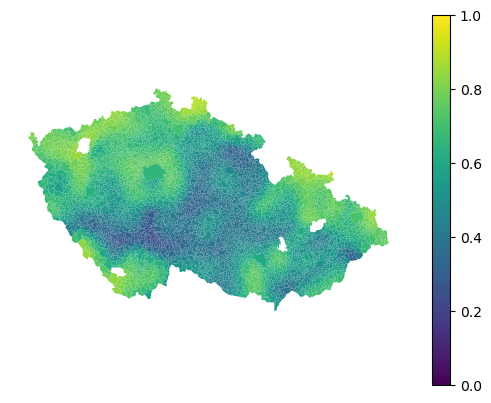

In [43]:
elections_data["local_r2"] = results.localR2
elections_data.plot("local_r2", legend=True, vmin=0, vmax=1).set_axis_off()

Higher local $R^2$ means that the model is able to use the data at each
municipality and its surrounding areas to provide a result that is
closer to the actual observed gain of Petr Pavel.

You can use the new GWR model and compare its predicted results with the
OLS done first and the actual results.

In [30]:
f, axs = plt.subplots(3, 1, figsize=(7, 14))
elections_data.plot(
    ols.predict(elections_data), legend=True, cmap="coolwarm", ax=axs[0]
)
elections_data.plot(
    results.predy.flatten(), legend=True, cmap="coolwarm", vmin=0, vmax=100, ax=axs[1]
).set_axis_off()

elections_data.plot(
    "PetrPavel", legend=True, cmap="coolwarm", vmin=0, vmax=100, ax=axs[2]
)
axs[0].set_title("OLS prediction")
axs[1].set_title("GWR prediction")
axs[2].set_title("Actual results")

axs[0].set_axis_off()
axs[1].set_axis_off()
axs[2].set_axis_off()

It is clear that the model is getting closer. Notice especially the
mountains in the southwest and north of the country. You can check this
even better by plotting residuals.

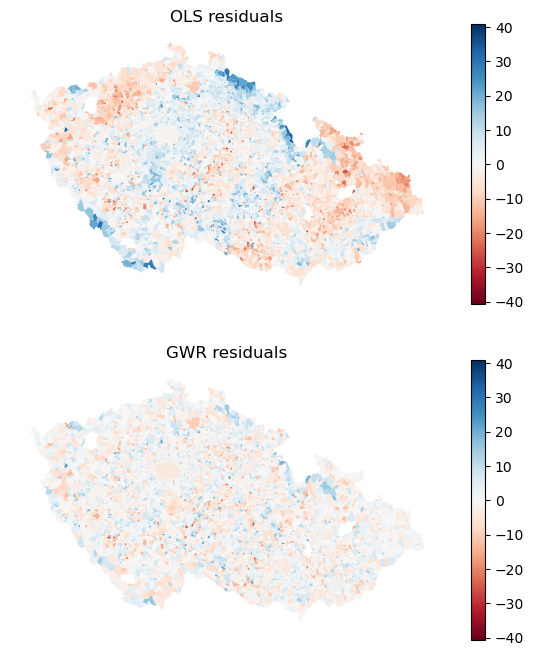

In [44]:
f, axs = plt.subplots(2, 1, figsize=(7, 8))
elections_data.plot(
    "residual",
    legend=True,
    cmap="RdBu",
    vmin=-max_residual,
    vmax=max_residual,
    ax=axs[0],
)
elections_data.plot(
    results.resid_response.flatten(),
    legend=True,
    cmap="RdBu",
    vmin=-max_residual,
    vmax=max_residual,
    ax=axs[1],
)
axs[0].set_title("OLS residuals")
axs[1].set_title("GWR residuals")

axs[0].set_axis_off()
axs[1].set_axis_off()

Apart from localised $R^2$, GWR also contains localised $\beta_k$
coefficients. While you can plot them directly (they are available as
`results.params`), you should also understand whether the coefficients
are statistically significant. For that, you first need to understand
what is the critical value of $t$. It is reported in the summary above
but not available as an attribute.

The `results` object contains the adjusted alpha values for 0.1, 0.05
and 0.01 levels of significance:

In [45]:
results.adj_alpha

array([1.68954569e-03, 8.44772843e-04, 1.68954569e-05])

You can use the selected alpha value together with the
`results.critical_tval()` method to get the critical value of $t$.

In [46]:
sig95 = results.adj_alpha[1]
critical_t = results.critical_tval(alpha=sig95)
critical_t

3.339312909177201

If a coefficient estimate has an absolute value of $t$ greater than
3.33, then it is statistically significant. You can use this level to
mask out the coefficients on the maps below making a distinction between
significant and non-significant values.

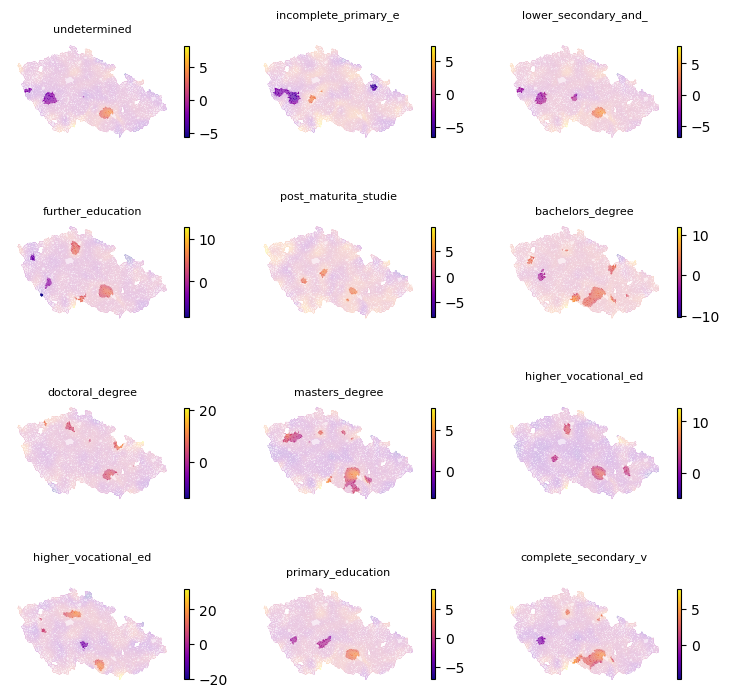

In [ ]:
significant = np.abs(results.tvalues) > critical_t
# vyssi beta koeficient ukazuje, ze dana promenna ma vyssi vliv na vysledek!!!! - to znamena, ze v Brne lze mnohem lepe vysvetlit volebni vysledky, nez v jinych obcich
fig, axs = plt.subplots(4, 3, figsize=(9, 9))
axs = axs.flatten()
for i, name in enumerate(independent_names[1:-1]):
    significant_mask = significant[:, i + 1]
    elections_data.plot(results.params[:, i + 1], cmap="plasma", ax=axs[i], legend=True, legend_kwds=dict(shrink=.6))
    elections_data[~significant_mask].plot(color="white", ax=axs[i], alpha=.9)
    axs[i].set_title(name[:20], fontdict={'fontsize': 8})
    axs[i].set_axis_off()

It seems that the coefficients are significant only in some areas, so
you need to be careful when drawing conclusions here. This can be due to
a lack of relationship or a small sample size. Try for yourself how the
significance changes if you increase the bandwidth. But be careful as
too large a bandwidth may miss regional differences and a bandwidth that
would cover the whole country would be equal to the OLS model.

> **Adaptive bandwidth**
>
> If you’d like to use the adaptive bandwidth, you can use same tools.
> Just specify `fixed=False` in both `Sel_BW` and `GWR`.
>
> ``` py
> sel_bw = mgwr.sel_bw.Sel_BW(coords, y, X, fixed=False)
> bw = sel_bw.search()
> ```
>
> ``` py
> adaptive = mgwr.gwr.GWR(coords, y, X, bw=bw, fixed=False, name_x=independent_names[1:])
> results_adaptive = adaptive.fit()
> ```

> **Additional reading**
>
> Have a look at the chapter [*Spatial
> Regression*](https://geographicdata.science/book/notebooks/11_regression.html#spatial-regimes)
> from the Geographic Data Science with Python by @rey2023geographic for
> more details and some other extensions.
>
> If you’d like to learn the details of GWR, *Geographically Weighted
> Regression* by @fotheringham2002geographically is a good start.

## Acknowledgements

The first part of this section loosely follows the *Spatial Regression*
chapter from the *Geographic Data Science with Python* by
@rey2023geographic. The section of GWR is inspired by the *Spatial
Modelling for Data Scientists* course by @Rowe2023spatial.